In [1]:
import os
data_path=r"C:\Users\thoma\Internship\RNN LSTM model\Input data\InorganicInchiNames.txt"

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import datetime
from math import ceil
from sklearn.model_selection import train_test_split

#################################################################################
# Functions
#################################################################################
def loadInputsTargets(data_path, max_samples, max_inp_length=200, max_targ_length=200, start_token='\t',
                                                                            end_token='\n', incol=0, targcol=2):
    """ -> list, list, int
    Load inputs and targets from a tsv file
    """
    input_list = []
    target_list =[]
    # Store true number of samples
    with open(data_path, "r", encoding="utf-8") as f:
        lines = f.read().split("\n")
    for line in lines[: min(max_samples, len(lines) - 1)]:
        # Get input and target, and pad target
        cur_line = line.split("\t")
        inp = cur_line[incol]
        targ = cur_line[targcol]
        targ = start_token + targ + end_token
        # Only accept input and targ below specified length
        if (len(inp) <= max_inp_length) and (len(targ) <= max_targ_length):
            input_list.append(inp)
            target_list.append(targ)
    return input_list, target_list

def generateAsciiAlphabet(start_code=32, final_code=126, start_token=None, end_token=None, pad_token='Ø', additions=[]):
    """ (int, int, char, char, char, list of chars) -> list
    Generates a set of ascii tokens with decimal code from start_code to final_code inclusive.
    Also adds any extra chars in additions.
    The pad token will be the first item in the list
    """
    alphabet = []
    if pad_token and len(pad_token) == 1:
        alphabet.append(pad_token)
    if start_token and len(start_token) == 1:
        alphabet.append(start_token)
    if end_token and len(end_token) == 1:
        alphabet.append(end_token)

    asc = [chr(x) for x in range(start_code, final_code+1)]
    alphabet.extend(asc)
    alphabet.extend(additions)

    return alphabet

def generateEmpiricalAlphabet(sample_list, additions=[]):
    """ list -> list
    Generate alphabet for a list of strings
    Returns a sorted list.
    """
    alphabet = set()
    for sample in sample_list:
        for char in sample:
            if char not in alphabet:
                alphabet.add(char)
                print("Found new character '{}' in:".format(char))
                print(sample.strip())
                print("Adding it to the alphabet.")
                print("")
    for c in additions:
        alphabet.add(c)
    return sorted(list(alphabet))

# Sample generator
def genSample(input_list, target_list, input_token_index, target_token_index, pad_token):
    """ -> generator
    Generator for loading samples on the fly
    """
    for (inp, targ) in zip(input_list, target_list):
        encoder_input_sample = [input_token_index[x] for x in inp]
        # We don't need to input the end token to the decoder, it just
        # needs to be predicted
        decoder_input_sample = [target_token_index[x] for x in targ[:-1]]
        # decoder_target_sample is ahead of decoder_input_sample by one timestep
        decoder_target_sample = [target_token_index[x] for x in targ[1:]]
        yield ((encoder_input_sample, decoder_input_sample), decoder_target_sample)

#################################################################################
# Procedural bit
#################################################################################
keras.backend.clear_session()

# Set random seed
from numpy.random import seed
seed(4238943)
from tensorflow.random import set_seed
set_seed(3824088)

# Path to the data txt file on disk.
#data_path = 'InorganicInchiNames.txt'
max_samples = 67781 # Number of samples to train on.
#data_path = 'MetallicsReconnectedNames.txt'
#max_samples = 164799 # Number of samples to train on.

# Constants
batch_size = 512  # Batch size for training.
epochs = 50 #30 # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.

max_encoder_seq_length = 200
max_decoder_seq_length = 128
start_token = '\t'
end_token = '\n'
pad_token = 'Ø'

# Load training data
print('Loading inputs and outputs')
input_list, target_list = loadInputsTargets(data_path, max_samples, max_inp_length=max_encoder_seq_length,
        max_targ_length=max_decoder_seq_length, start_token=start_token, end_token=end_token, incol=0, targcol=1)

# Generate alphabets as sorted lists
print('Generating alphabets')
input_alphabet = generateAsciiAlphabet(pad_token=pad_token)
print('Input alphabet:')
print(input_alphabet)

# Using start and end token for targets only
target_alphabet = generateAsciiAlphabet(start_token=start_token, end_token=end_token, pad_token=pad_token,
                                                                                            additions=['λ','²','⁶','λ','₇','⁵','⁴','⁷','³','⁸','¹','⁰','⁹','₂','₄','₃','₁','₉','₆','₅','λ','⁻','₈'])

print('Target alphabet:')
print(target_alphabet)

num_encoder_tokens = len(input_alphabet)
num_decoder_tokens = len(target_alphabet)

assert(len(input_list) == len(target_list))

# Split into training set and validation set
input_train, input_val, target_train, target_val = train_test_split(
        input_list, target_list, test_size=0.2, random_state=24)

print("Number of samples:", len(input_list))
print("Number of training samples:", len(input_train))
print("Number of validation samples:", len(input_val))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for input:", max_encoder_seq_length)
print("Max sequence length for target:", max_decoder_seq_length)
print('')

# Build token -> index dictionaries
inchi_token_index = dict([(char, i) for i, char in enumerate(input_alphabet)])
iupac_token_index = dict([(char, i) for i, char in enumerate(target_alphabet)])

# Get training set in tf.data dataset format
trainset = tf.data.Dataset.from_generator(
        lambda: genSample(input_train, target_train, inchi_token_index,
                                                    iupac_token_index, pad_token),
        output_types=((tf.int32, tf.int32), tf.int32),
        output_shapes=(
            (tf.TensorShape([None]),
                tf.TensorShape([None])),
            tf.TensorShape([None]))
)

trainset = trainset.padded_batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Get validation set in tf.data dataset format
valset = tf.data.Dataset.from_generator(
        lambda: genSample(input_val, target_val, inchi_token_index,
                                                    iupac_token_index, pad_token),
        output_types=((tf.int32, tf.int32), tf.int32),
        output_shapes=(
            (tf.TensorShape([None]),
                tf.TensorShape([None])),
            tf.TensorShape([None]))
)

valset = valset.padded_batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Build the model
# TODO: add weight normalization

# Define encoder
# The embedding matrix is generally num_tokens x embedding_dim
encoder_inputs = keras.Input(shape=(None,), dtype=tf.int32)
encoder_embedding_mat = np.eye(num_encoder_tokens)
encoder_embedding_layer = keras.layers.Embedding(
        num_encoder_tokens,
        num_encoder_tokens, #Embedding dimension is same as number of tokens
        embeddings_initializer = keras.initializers.Constant(encoder_embedding_mat), #Not actually constant
        trainable=False, #This makes embeddings constant
        mask_zero=True
)
encoder_embedded_seqs = encoder_embedding_layer(encoder_inputs)
#encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True, dropout=0.5)
encoder_outputs, state_h, state_c = encoder(encoder_embedded_seqs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Define decoder
decoder_inputs = keras.Input(shape=(None,), dtype=tf.int32) #Accepts batch of lists
decoder_embedding_mat = np.eye(num_decoder_tokens)
decoder_embedding_layer = keras.layers.Embedding(
        num_decoder_tokens,
        num_decoder_tokens, #Embedding dimension is same as number of tokens
        embeddings_initializer = keras.initializers.Constant(decoder_embedding_mat), #Not actually constant
        trainable=False, #This makes embeddings constant
        mask_zero=True
) # Convert lists to embeddings
decoder_embedded_seqs = decoder_embedding_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.5)
decoder_outputs, _, _ = decoder_lstm(decoder_embedded_seqs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation=None)
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

# Loss is sum of losses over batch, from logits
loss_function = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Optimizer
optimizer = keras.optimizers.Adam(
        learning_rate=0.001,
        clipnorm=3
)

model.compile(
    optimizer=optimizer, loss=loss_function, metrics=["accuracy"]
)

# Tensorboard setup
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Early stopping setup
stopping_callback = tf.keras.callbacks.EarlyStopping(
        min_delta = 1e-4,
        patience = 3,
        restore_best_weights=True
)


Loading inputs and outputs
Generating alphabets
Input alphabet:
['Ø', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~']
Target alphabet:
['Ø', '\t', '\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's'

In [3]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png')

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [4]:

history=model.fit(
    trainset,
#    steps_per_epoch=ceil(len(input_train)/batch_size),
    validation_data=valset,
#    validation_steps=ceil(len(input_val)/batch_size),
    epochs=epochs,
    callbacks=[stopping_callback]
)

# Save model
model.save("s2s")


Epoch 1/50
105/105 [==============================] - 19s 103ms/step - loss: 0.9025 - accuracy: 0.1281 - val_loss: 0.8154 - val_accuracy: 0.2032
Epoch 2/50
105/105 [==============================] - 12s 118ms/step - loss: 0.7522 - accuracy: 0.2456 - val_loss: 0.6579 - val_accuracy: 0.3625
Epoch 3/50
105/105 [==============================] - 42s 407ms/step - loss: 0.6677 - accuracy: 0.3129 - val_loss: 0.5688 - val_accuracy: 0.4366
Epoch 4/50
105/105 [==============================] - 39s 371ms/step - loss: 0.6230 - accuracy: 0.3517 - val_loss: 0.5165 - val_accuracy: 0.4799
Epoch 5/50
105/105 [==============================] - 32s 274ms/step - loss: 0.5894 - accuracy: 0.3820 - val_loss: 0.4731 - val_accuracy: 0.5217
Epoch 6/50
105/105 [==============================] - 9s 82ms/step - loss: 0.5624 - accuracy: 0.4080 - val_loss: 0.4412 - val_accuracy: 0.5494
Epoch 7/50
105/105 [==============================] - 9s 83ms/step - loss: 0.5418 - accuracy: 0.4278 - val_loss: 0.4154 - val_accura

INFO:tensorflow:Assets written to: s2s\assets


INFO:tensorflow:Assets written to: s2s\assets


In [6]:
import os
PATH = r"C:\Users\thoma\Internship\RNN LSTM model\Weights\InorganicInChiWeights"
model.save(PATH)

INFO:tensorflow:Assets written to: C:\Users\thoma\Internship\RNN LSTM model\Weights\InorganicInChiWeights\assets


INFO:tensorflow:Assets written to: C:\Users\thoma\Internship\RNN LSTM model\Weights\InorganicInChiWeights\assets


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


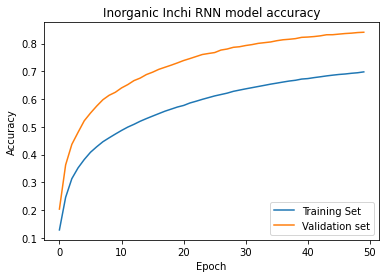

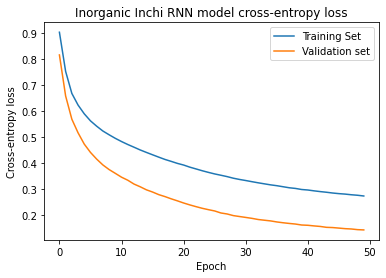

In [7]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Inorganic Inchi RNN model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Validation set'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Inorganic Inchi RNN model cross-entropy loss')
plt.ylabel('Cross-entropy loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Validation set'], loc='upper right')
plt.show()

Epoch:   1 Cross-entropy loss: 0.75221848
Epoch:   6 Cross-entropy loss: 0.54181713
Epoch:  11 Cross-entropy loss: 0.47161365
Epoch:  16 Cross-entropy loss: 0.42297095
Epoch:  21 Cross-entropy loss: 0.38454822
Epoch:  26 Cross-entropy loss: 0.35352647
Epoch:  31 Cross-entropy loss: 0.32878968
Epoch:  36 Cross-entropy loss: 0.30943456
Epoch:  41 Cross-entropy loss: 0.29361963
Epoch:  46 Cross-entropy loss: 0.28114146


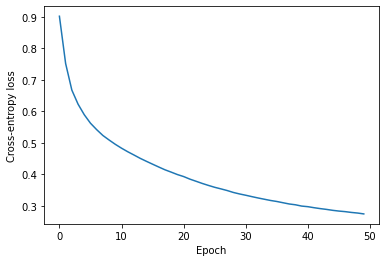

In [8]:
d=history.history
plt.plot(range(epochs), d.get("loss"))
plt.ylabel("Cross-entropy loss")
plt.xlabel('Epoch');

loss=d.get('loss')

for i in range(len(loss)):
  if i%5 == 1:
    print(f'Epoch: {i:3} Cross-entropy loss: {loss[i]:10.8f}')